### Step 1

In [1]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

price_demand_data = pd.read_csv("price_demand_data.csv")

# Reshape data for regression model
X = price_demand_data['price'].values.reshape(-1, 1)
y = price_demand_data['demand'].values

# Fit linear regression
model = LinearRegression()
model.fit(X, y)

# Retrieve the coefficients
beta_0 = model.intercept_
beta_1 = model.coef_[0]

# Calculate residuals
predicted_demand = model.predict(X)
residuals = y - predicted_demand

beta_0, beta_1, residuals[:5]

(1924.7175435291088,
 -1367.7125241625981,
 array([-205.61939316,   22.51522725,  -84.78538929, -108.06777082,
         116.74397483]))

### Steps 2-3

In [2]:
from gurobipy import Model, GRB, quicksum

# Constants
c = 0.5   # cost to produce one unit
g = 0.75  # cost per rush order
t = 0.15  # disposal fee per unit
p = 1     # price

# Simulate demand at p=1 using residuals
simulated_demand_p1 = beta_0 + beta_1 * p + residuals

# Set up the Linear Programming model in Gurobi to find the optimal production quantity q
model = Model('Optimal_Production')

# Define the variable for the quantity to produce
q = model.addVar(lb=0, name="q")

# Define sales, rush, and excess variables for each day
rush_orders = [model.addVar(lb=0, ub=GRB.INFINITY, name=f"rush_{i}") for i, _ in enumerate(simulated_demand_p1)]
excess_production = [model.addVar(lb=0, ub=GRB.INFINITY, name=f"excess_{i}") for i, _ in enumerate(simulated_demand_p1)]

for i, d in enumerate(simulated_demand_p1):

    # Rush orders are needed if demand exceeds production
    model.addConstr(rush_orders[i] >= d - q, name=f"Rush_Need_{i}")
    model.addConstr(rush_orders[i] >= 0, name=f"Rush_Positive_{i}")

    # Excess production occurs if production exceeds demand
    model.addConstr(excess_production[i] >= q - d, name=f"Excess_Prod_{i}")
    model.addConstr(excess_production[i] >= 0, name=f"Excess_Positive_{i}")

# Objective function: Maximize expected profit considering revenue, production cost, rush order cost, and disposal fee
objective = quicksum(p * simulated_demand_p1[i] - c * q - g * rush_orders[i] - t * excess_production[i] for i in range(len(simulated_demand_p1)))

model.setObjective(objective, GRB.MAXIMIZE)

# Solve the model
model.optimize()

# Output the optimal production quantity
optimal_quantity = q.X if model.status == GRB.OPTIMAL else None
optimal_quantity

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-20
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 PRO 6860Z with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 396 rows, 199 columns and 594 nonzeros
Model fingerprint: 0x41cf0550
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 9e+02]
Presolve removed 198 rows and 0 columns
Presolve time: 0.01s
Presolved: 198 rows, 199 columns, 396 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5143497e+04   5.514350e+04   0.000000e+00      0s
      99    2.2916883e+04   0.000000e+00   0.000000e+00      0s

Solved in 99 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.291688300e+04


471.86537959089355

### Step 4

In [6]:
from gurobipy import Model, GRB, quicksum

# Constants
c = 0.5   # cost to produce one unit
g = 0.75  # cost per rush order
t = 0.15  # disposal fee per unit

# Gurobi Model Setup
model = Model('Optimal_Price_and_Production')

# Define the variables for the price and quantity to produce
p = model.addVar(lb=0, name="price")
q = model.addVar(lb=0, name="quantity")

# Define rush, and excess variables for each day
rush_orders = model.addVars(len(residuals), lb=0, name="rush_orders")
excess_production = model.addVars(len(residuals), lb=0, name="excess_production")

# Objective function: Maximize expected profit
objective = quicksum(p * (beta_0 + beta_1 * p + residuals[i]) - c * q - g * rush_orders[i] - t * excess_production[i] for i in range(len(residuals)))
model.setObjective(objective, GRB.MAXIMIZE)

# Constraints for dynamically computed demand affecting rush orders and excess production
for i, epsilon in enumerate(residuals):
    demand = beta_0 + beta_1 * p + epsilon
    model.addConstr(rush_orders[i] >= demand - q, name=f"Rush_Need_{i}")
    model.addConstr(rush_orders[i] >= 0, name=f"Rush_Positive_{i}")
    model.addConstr(excess_production[i] >= q - demand, name=f"Excess_Prod_{i}")
    model.addConstr(excess_production[i] >= 0, name=f"Excess_Positive_{i}")

# Solve the model
model.optimize()

# Output the optimal price and production quantity
optimal_price = p.X if model.status == GRB.OPTIMAL else None
optimal_quantity = q.X if model.status == GRB.OPTIMAL else None

(optimal_price, optimal_quantity)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 PRO 6860Z with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 396 rows, 200 columns and 792 nonzeros
Model fingerprint: 0xb216605b
Model has 1 quadratic objective term
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e-01, 2e+05]
  QObjective range [3e+05, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 2e+03]
Presolve removed 198 rows and 0 columns
Presolve time: 0.01s
Presolved: 198 rows, 200 columns, 594 nonzeros
Presolved model has 1 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.950e+04
 Factor NZ  : 1.970e+04
 Factor Ops : 2.607e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual 

(0.9536264966210826, 535.2910055343532)

### Step 6

In [7]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt

# Load your original data
price_demand_data = pd.read_csv("price_demand_data.csv")

# Sample with replacement
sample_data = price_demand_data.sample(n=len(price_demand_data), replace=True)

# Fit regression to the bootstrap sample
X_sample = sample_data['price'].values.reshape(-1, 1)
y_sample = sample_data['demand'].values
model = LinearRegression()
model.fit(X_sample, y_sample)
beta_0_sample = model.intercept_
beta_1_sample = model.coef_[0]

# Setup Gurobi model
m = Model('Bootstrap_Optimization')
p = m.addVar(lb=0, name="price")
q = m.addVar(lb=0, name="quantity")

# Objective function
revenue = p * q
cost = c * q
objective = revenue - cost
m.setObjective(objective, GRB.MAXIMIZE)

# Constraints based on sampled model
demand = beta_0_sample + beta_1_sample * p
m.addConstr(q <= demand, name="demand_constraint")

# Solve the model
m.optimize()

# Output the results if the model is optimal
if m.status == GRB.OPTIMAL:
    optimal_price = p.X
    optimal_quantity = q.X
    expected_profit = m.objVal

    print(f"Optimal Price: {optimal_price}")
    print(f"Optimal Quantity: {optimal_quantity}")
    print(f"Expected Profit: {expected_profit}")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 PRO 6860Z with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1 rows, 2 columns and 2 nonzeros
Model fingerprint: 0x35a8c3d1
Model has 1 quadratic objective term
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [5e-01, 5e-01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 2e+03]

Continuous model is non-convex -- solving as a MIP

Found heuristic solution: objective -0.0000000
Presolve time: 0.00s
Presolved: 3 rows, 3 columns, 6 nonzeros
Presolved model has 1 bilinear constraint(s)
Variable types: 3 continuous, 0 integer (0 binary)
Found heuristic solution: objective 280.4247917

Root relaxation: objective 5.836736e+02, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     O

### Step 7

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from gurobipy import Model, GRB, quicksum
import seaborn as sns
import matplotlib.pyplot as plt

# Load your original data
price_demand_data = pd.read_csv("price_demand_data.csv")

# Number of bootstrap samples
num_samples = 500

# Lists to store results
optimal_prices = []
optimal_quantities = []
expected_profits = []

# Bootstrap sampling and optimization
for _ in range(num_samples):
    # Sample with replacement
    sample_data = price_demand_data.sample(n=len(price_demand_data), replace=True)
    
    # Fit regression to the bootstrap sample
    X_sample = sample_data['price'].values.reshape(-1, 1)
    y_sample = sample_data['demand'].values
    model = LinearRegression()
    model.fit(X_sample, y_sample)
    beta_0_sample = model.intercept_
    beta_1_sample = model.coef_[0]

    # Setup Gurobi model
    m = Model('Bootstrap_Optimization')
    p = m.addVar(lb=0, name="price")
    q = m.addVar(lb=0, name="quantity")

    # Objective function
    revenue = p * q
    cost = c * q
    objective = revenue - cost
    m.setObjective(objective, GRB.MAXIMIZE)

    # Constraints based on sampled model
    demand = beta_0_sample + beta_1_sample * p
    m.addConstr(q <= demand, name="demand_constraint")
    
    # Solve the model
    m.optimize()

    # Record the results if the model is optimal
    if m.status == GRB.OPTIMAL:
        optimal_prices.append(p.X)
        optimal_quantities.append(q.X)
        expected_profits.append(m.objVal)

# Create a DataFrame from the results
results_df = pd.DataFrame({
    'Optimal Price': optimal_prices,
    'Optimal Quantity': optimal_quantities,
    'Expected Profit': expected_profits
})

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 PRO 6860Z with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1 rows, 2 columns and 2 nonzeros
Model fingerprint: 0xf959130f
Model has 1 quadratic objective term
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [5e-01, 5e-01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 2e+03]

Continuous model is non-convex -- solving as a MIP

Found heuristic solution: objective -0.0000000
Presolve time: 0.00s
Presolved: 3 rows, 3 columns, 6 nonzeros
Presolved model has 1 bilinear constraint(s)
Variable types: 3 continuous, 0 integer (0 binary)
Found heuristic solution: objective 282.0466949

Root relaxation: objective 5.937466e+02, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     O

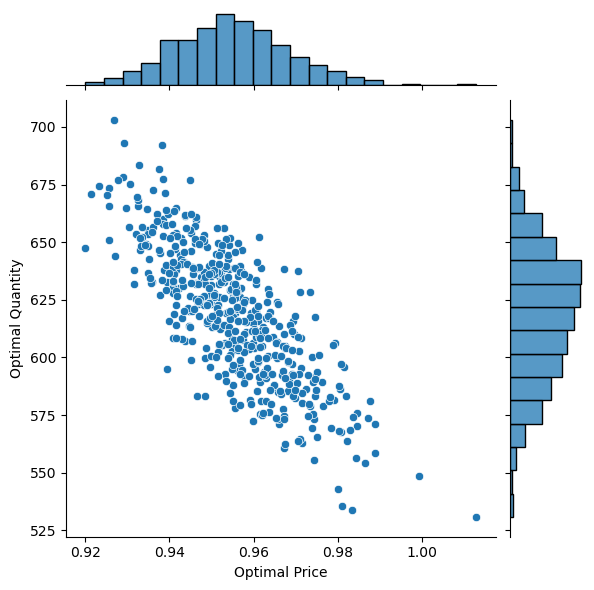

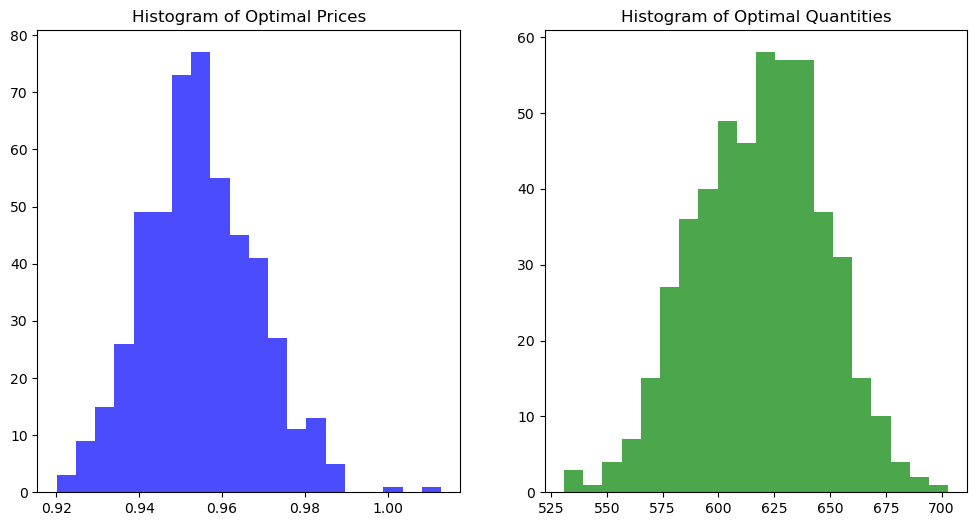

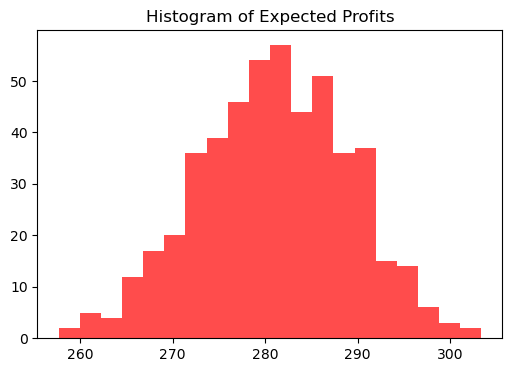

In [17]:
# Create scatterplot with histograms on the x and y axes
sns.jointplot(data=results_df, x='Optimal Price', y='Optimal Quantity', kind="scatter")
plt.show()

# Histograms of Optimal Price and Optimal Quantity
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(optimal_prices, bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Optimal Prices')

plt.subplot(1, 2, 2)
plt.hist(optimal_quantities, bins=20, color='green', alpha=0.7)
plt.title('Histogram of Optimal Quantities')
plt.show()

# Histogram of Expected Profits
plt.figure(figsize=(6, 4))
plt.hist(expected_profits, bins=20, color='red', alpha=0.7)
plt.title('Histogram of Expected Profits')
plt.show()